In [1]:
pip install numpy opencv-python-headless matplotlib scikit-learn tensorflow --user

Note: you may need to restart the kernel to use updated packages.


Found 1636 images belonging to 5 classes.
Found 406 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.2854 - loss: 3.3860 - val_accuracy: 0.2291 - val_loss: 6.9472 - learning_rate: 0.0010
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.3798 - loss: 3.2762 - val_accuracy: 0.1823 - val_loss: 6.1805 - learning_rate: 0.0010
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.3970 - loss: 3.0183 - val_accuracy: 0.3251 - val_loss: 3.0292 - learning_rate: 0.0010
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.4970 - loss: 2.5070 - val_accuracy: 0.4113 - val_loss: 2.4283 - learning_rate: 0.0010
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.4928 - loss: 2.3609 - val_accuracy: 0.5271 - val_loss: 2.0671 - learning_rate: 0.0010
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.5372 - loss: 2.0296 - val_accuracy: 0.5567 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step

Evaluación final por clase:
Clase 'bandeja paisa': 80.00% de precisión (16 de 20 correctas)
Clase 'bunuelos': 90.00% de precisión (18 de 20 correctas)
Clase 'empanadas': 85.00% de precisión (17 de 20 correctas)
Clase 'sancocho': 65.00% de precisión (13 de 20 correctas)
Clase 'tamales': 85.00% de precisión (17 de 20 correctas)


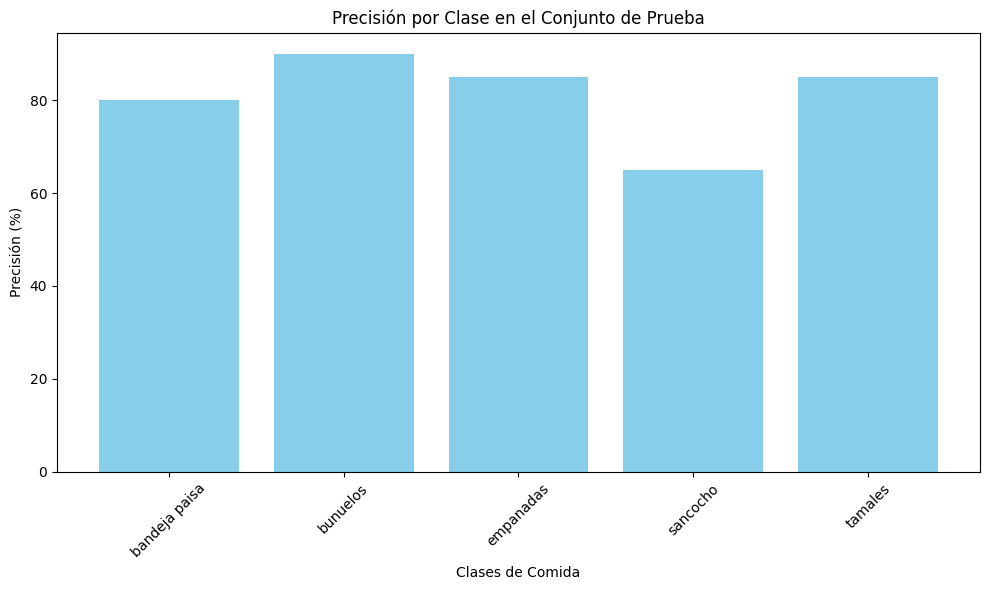

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.8198 - loss: 0.8649

Accuracy final total: 0.81


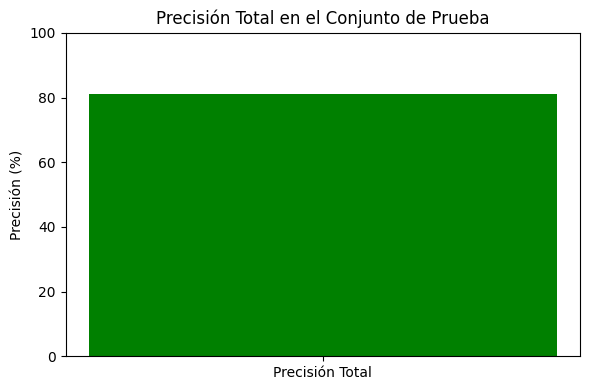

In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import cv2
import random

# 1. Preprocesamiento de Datos
train_dir = 'imagenes/entrenamiento'
test_dir = 'imagenes/prueba'

# Generadores de datos para carga eficiente y aumentación de imágenes
def equalize_histogram(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0].astype(np.uint8))
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img_output

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    preprocessing_function=equalize_histogram,  # Modificación con histograma de color
    horizontal_flip=True,  # Aumentación para evitar overfitting
    rotation_range=20,     # Rotación aleatoria
    width_shift_range=0.2, # Desplazamiento horizontal
    height_shift_range=0.2 # Desplazamiento vertical
)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=8,
    class_mode='categorical',
    subset='validation'
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=8,
    class_mode='categorical',
    shuffle=False  # Deshabilitar el rebarajado para mantener consistencia en la evaluación
)

# 2. Definición del Modelo
model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Entrenamiento Supervisado con Early Stopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
model.fit(train_data, validation_data=val_data, epochs=50, callbacks=[early_stopping, reduce_lr])

# Exportar el modelo entrenado
model.save('modelo_comida.h5')

# Evaluación final - Uso de matplotlib
def evaluate_model(model, test_data):
    class_labels = list(test_data.class_indices.keys())
    correct_per_class = [0] * len(class_labels)
    total_per_class = [0] * len(class_labels)

    for i in range(len(test_data)):
        x, y_true = test_data[i]
        predictions = model.predict(x)
        for j in range(len(predictions)):
            predicted_class = np.argmax(predictions[j])
            true_class = np.argmax(y_true[j])
            total_per_class[true_class] += 1
            if predicted_class == true_class:
                correct_per_class[true_class] += 1

    print("\nEvaluación final por clase:")
    class_accuracies = []
    for idx, label in enumerate(class_labels):
        accuracy = (correct_per_class[idx] / total_per_class[idx]) * 100 if total_per_class[idx] > 0 else 0
        class_accuracies.append(accuracy)
        print(f"Clase '{label}': {accuracy:.2f}% de precisión ({correct_per_class[idx]} de {total_per_class[idx]} correctas)")

    # Gráfica de precisión por clase
    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_accuracies, color='skyblue')
    plt.xlabel('Clases de Comida')
    plt.ylabel('Precisión (%)')
    plt.title('Precisión por Clase en el Conjunto de Prueba')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Evaluación general
    overall_loss, overall_accuracy = model.evaluate(test_data)
    print(f'\nAccuracy final total: {overall_accuracy:.2f}')

    # Evaluación total
    plt.figure(figsize=(6, 4))
    plt.bar(['Precisión Total'], [overall_accuracy * 100], color='green')
    plt.ylabel('Precisión (%)')
    plt.title('Precisión Total en el Conjunto de Prueba')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

evaluate_model(model, test_data)